<a href="https://colab.research.google.com/github/diegoflxgarcia/NLP-ETL-tweets/blob/main/tweets_ETL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explorando NLP (Natural Language Processing) em um Pipeline de ETL

**Objetivo: Analisar os sentimentos e extrair palavras-chaves de um conjunto de tweets selecionados diretamente do Twitter (X), sobre o novo jogo da Microsoft Starfield, utilizando a API do Google Cloud Natural Language. Isso tudo dentro do contexto de um pipeline ETL.**

Observação: O objetivo desse notebook **NÃO** é refletir um insight real sobre o tema (o jogo exclusivo da Microsoft Starfield) mas sim testar as ferramentas de modelos de linguagem para enriquecimento de dados, uma vez que minha seleção não foi uma amostragem aleatória, pelo contrário, selecionei tweets com conteúdo que julguei interessante ser analisado pelo modelo de linguagem (um conjunto de modelos na verdade) do Google Cloud Natural Language.

## **E**xtract

Devido as restrições de acesso aos endpoints da API do Twitter impostas recentemente (fevereiro/2023), não é possível extrair diretamente da mesma os tweets para analisa-los sem ter que pagar pelo uso.

Assim decidi simplificar essa etapa, selecionei manualmente 13 tweets pela palavra-chave "Starfield" nos últimos tweets dessa palavra chave e organizei os mesmos em um arquivo JSON (como é de costume ser fornecido pelas APIs) com a  ajuda do chat GPT para a etapa posterior do pipeline, usei o HTML de cada tweet para o chat GPT converter e compilar tudo no arquivo em formato JSON.

In [1]:
# Importando nosso querido Pandas e lendo o arquivo JSON em Dataframe
import pandas as pd
df = pd.read_json('dados_starfield.json')
display(df)

,usuario_1,usuario_2,usuario_3,usuario_4,usuario_5,usuario_6,usuario_7,usuario_8,usuario_9,usuario_10,usuario_11,usuario_12,usuario_13
author,Skywakko (@Skywakko),matthew (@BifocalBore),Edin Rivera (@NewEdin_Faze),Noah McCay 🌵 (@NoahMakesMovies),DigitalThief (@Garret792),Hélastico (@Eliastico_1),"Myles, Is this easy mode? (@MowzaProduction)",Gerald (@cereal_killings),Dalerius (@Dalerius1),SunlessSketcher (@SunlessSketcher),DK_orleanss (@DkOrleanss),cmbrockman_ (@cmbrockman_),ChargersMemes (@ChargersMemes)
content,A mí no me gustó No Man’s Sky por lo mismo que...,havent even played baldurs gate 3 yet but im a...,Aver diria que la de Starfield se ve un poquit...,"Starfield is cool, and all. Like genuinely, I ...","Las cargas, que deberían haberlas disimulado. ...",Bon voilà après 15h de jeu j’ai désinstallé St...,Ship combat is fantastic. You want simulator l...,Ship combat in Starfield is easily some of the...,Reality\nHi-Fi Rush - good (indie game)\nMinec...,I think my favorite thing about #Starfield is ...,I’m a Bethesda fan but starfield is a 7 at bes...,I LOVE starfield but it is not the best RPG of...,The way Starfield integrated the New Game+ fea...
date,"October 5, 2023","October 5, 2023","October 5, 2023","October 5, 2023","October 5, 2023","October 5, 2023","October 5, 2023","October 5, 2023","October 5, 2023","October 5, 2023","October 5, 2023","October 5, 2023","October 5, 2023"
language,es,en,es,en,es,fr,en,en,en,en,en,en,en


In [2]:
# Por questão de gosto apenas, irei transpor nosso dataframe...
df = df.T
display(df.head(6))

,author,content,date,language
usuario_1,Skywakko (@Skywakko),A mí no me gustó No Man’s Sky por lo mismo que...,"October 5, 2023",es
usuario_2,matthew (@BifocalBore),havent even played baldurs gate 3 yet but im a...,"October 5, 2023",en
usuario_3,Edin Rivera (@NewEdin_Faze),Aver diria que la de Starfield se ve un poquit...,"October 5, 2023",es
usuario_4,Noah McCay 🌵 (@NoahMakesMovies),"Starfield is cool, and all. Like genuinely, I ...","October 5, 2023",en
usuario_5,DigitalThief (@Garret792),"Las cargas, que deberían haberlas disimulado. ...","October 5, 2023",es
usuario_6,Hélastico (@Eliastico_1),Bon voilà après 15h de jeu j’ai désinstallé St...,"October 5, 2023",fr


Observação: As colunas "author" e "date" não são relevantes para as análises seguintes porém vou mante-las para apenas contextualizar.

## **T**ransform

Vamos realizar duas subetapas nessa etapa, utilizando a API do Google Cloud:
1. Análise de sentimentos de cada tweet
2. Determinação de palavras-chaves

### Antes de tudo, preparando a API do Google Cloud Natural Language

In [3]:
# Criando objeto de credenciais do pacote "google.oauth2" para autenticação
from google.oauth2 import service_account
credentials = service_account.Credentials.from_service_account_file('/content/credencial_GCNL.json')

# Autenticando e inicializando o objeto da API "client" do Google Cloud Natural Language
from google.cloud import language_v1
objeto_api = language_v1.LanguageServiceClient(credentials=credentials)

### Análise de sentimento
Vamos analisar a polaridade (número de -1 a 1 em geral, também chamado de "score") e a magnetude (um número maior ou igual a zero) dos respectivos tweets registrados em texto na coluna "content" de nosso dataframe.

Para isso vamos iterar nessa coluna e aplicar o método de analise de sentimentos da nossa API em cada iteração, por fim vamos guardar em dataframes separados as respostas da API (no caso as polaridades e magnetudes dos tweets).

[Documentação do GCNL (Google Cloud Natural Language)](https://cloud.google.com/natural-language/docs/analyzing-sentiment?hl=pt-br) sobre análise de sentimentos, implementado em Python.

In [4]:
"""EXEMPLO DE USO DO MÉTODO "analyze_sentiment" PARA ANÁLISE DE SENTIMENTO
   DE ACORDO COM DOCUMENTAÇÃO DO GCNL DE FORMA SIMPLIFICADA"""

# Texto exemplo
texto = "Estou muito feliz com o resultado do meu projeto!"

# Criando um objeto do tipo "document" com o texto para ser usando pelo método analyze_sentiment
document = language_v1.Document(content=texto, type_=language_v1.Document.Type.PLAIN_TEXT)

# Chamando o método analyze_sentiment
response = objeto_api.analyze_sentiment(request={'document': document})

# A análise de sentimento está no campo sentiment da resposta
sentiment = response.document_sentiment

# Agora podemos acessar a polaridade e a magnitude do sentimento
print(type(sentiment))
print(f"Polaridade: {sentiment.score}")
print(f"Magnitude: {sentiment.magnitude}")

<class 'google.cloud.language_v1.types.language_service.Sentiment'>
Polaridade: 0.8999999761581421
Magnitude: 0.8999999761581421


In [5]:
# Criando dataframes vazios que irão armazenar nossas polaridades e magnetudes dos respectivos tweets
polaridades, magnetudes = pd.DataFrame(), pd.DataFrame()

# Encapsulando o código referente a chamada da API do GCNL, a fim de melhorar a legibilidade
def analisar_sentimento_no_tweet(tweet: str=None) -> language_v1.types.language_service.Sentiment:
  tweet_doc = language_v1.Document(content=tweet, type_=language_v1.Document.Type.PLAIN_TEXT)
  resposta_api = objeto_api.analyze_sentiment(request={'document': tweet_doc})
  sentimento = resposta_api.document_sentiment
  return sentimento

# Iterando na coluna "content" para analisar cada sentimento dos tweets
for usuario, tweet in df['content'].items():
  sentimento = analisar_sentimento_no_tweet(tweet)
  polaridades = pd.concat([polaridades, pd.DataFrame(sentimento.score, index=[usuario], columns=['polaridade'])])
  magnetudes = pd.concat([magnetudes, pd.DataFrame(sentimento.magnitude, index=[usuario], columns=['magnetude'])])

In [6]:
# Saindo do forno nossos dois dataframes, das polaridades e magnetudes dos tweets...
display(polaridades, magnetudes)

,polaridade
usuario_1,-0.5
usuario_2,0.8
usuario_3,0.0
usuario_4,0.7
usuario_5,0.1
usuario_6,-0.6
usuario_7,0.1
usuario_8,-0.5
usuario_9,0.3
usuario_10,0.6


,magnetude
usuario_1,0.5
usuario_2,0.8
usuario_3,0.0
usuario_4,1.4
usuario_5,0.7
usuario_6,2.6
usuario_7,2.5
usuario_8,2.0
usuario_9,0.3
usuario_10,1.2


#### Produzindo uma nova métrica...
Agora vamos produzir uma nova métrica para os tweets combinando a polaridade e magnetude de cada, vamos chamar de "**Polaridade Ponderada**", da seguinte forma: se a polaridade for positiva a polaridade ponderada é igual ao valor da magnetude e se for negativa o seu valor é igual o da magnetude com sinal negativo.

Para isso, vamos juntar os dois dataframes anteriores e usar o método pd.apply implementando a função lambda de acordo com a fórmula acima e evitando a exceção de divisão por zero.

Por fim vamos adicionar uma nova coluna com as polaridades ponderadas ao novo dataframe gerado pela união dos dois anteriores.

In [7]:
# Unindo os dataframes anteriores
df_sentimentos = pd.concat([polaridades, magnetudes], axis=1)
display(df_sentimentos)

,polaridade,magnetude
usuario_1,-0.5,0.5
usuario_2,0.8,0.8
usuario_3,0.0,0.0
usuario_4,0.7,1.4
usuario_5,0.1,0.7
usuario_6,-0.6,2.6
usuario_7,0.1,2.5
usuario_8,-0.5,2.0
usuario_9,0.3,0.3
usuario_10,0.6,1.2


In [8]:
# Criando uma nova coluna no nosso novo dataframe com as polaridades ponderadas
df_sentimentos['polaridade_ponderada'] = df_sentimentos.apply(lambda x: 1*x['magnetude'] if x['polaridade'] >= 0 else -1*x['magnetude'], axis=1)

# E pronto! Nosso dataframe "sentimental" está concluído
display(df_sentimentos)

,polaridade,magnetude,polaridade_ponderada
usuario_1,-0.5,0.5,-0.5
usuario_2,0.8,0.8,0.8
usuario_3,0.0,0.0,0.0
usuario_4,0.7,1.4,1.4
usuario_5,0.1,0.7,0.7
usuario_6,-0.6,2.6,-2.6
usuario_7,0.1,2.5,2.5
usuario_8,-0.5,2.0,-2.0
usuario_9,0.3,0.3,0.3
usuario_10,0.6,1.2,1.2


### Palvras-chaves
Vamos agora usar o método relacionado a determinação das palavras-chaves em textos, aplicado aos nossos tweets.

Porém antes da aplicação do método vamos realizar o pré-processamento de texto para melhorar o resultado fornecido pela API do GCNL, para isso vamos utilizar o pacote spaCy para tokenizar e remover stop words (palavras sem importância).

Além disso, como os tweets estão em vários idiomas vamos utilizar o modulo translate para traduzir em um único idioma padrão, português no caso, e assim vamos utilizar o modelo de linguagem em português do spaCy.

Por fim, depois do processamento das palavras chaves, vamos construir um dataframe com os usuários nos índices e seus tweets com as palavras-chaves na segunda coluna.

[Documentação do GCNL (Google Cloud Natural Language)](https://cloud.google.com/natural-language/docs/analyzing-entities?hl=pt-br) sobre analise de entidades, implementado em Python.

In [9]:
"""EXEMPLO DE USO DO MÉTODO "analyze_entities" PARA ANÁLISE DE PALAVRAS-CHAVES
   DE ACORDO COM DOCUMENTAÇÃO DO GCNL DE FORMA SIMPLIFICADA"""
# Texto exemplo
text = "Este é um exemplo de um texto de teste. Vamos extrair palavras-chave importantes deste texto."

# Criando um objeto do tipo "document" com o texto para ser usando pelo método analyze_entities
document = language_v1.Document(content=text, type_=language_v1.Document.Type.PLAIN_TEXT)

# Chamando o método analyze_entities
response = objeto_api.analyze_entities(request={'document': document, 'encoding_type': language_v1.EncodingType.UTF8})

# Armazenando as palavras-chaves em uma lista
keywords = [entity.name for entity in response.entities]

# E vejamos...
print(keywords)

['exemplo', 'texto', 'texto', 'teste', 'palavras-chave', 'um', 'um']


In [10]:
# Instalando o translate e o modelo de linguagem do spaCy no idioma pt
!pip install translate
!python -m spacy download pt_core_news_sm

2023-10-18 21:18:57.075676: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 21:18:58.956746: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 46.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [11]:
# Pré-processamento com o spaCy com auxilio do translate
texto_teste = 'Este é um exemplo de um texto de teste (?). Vamos extrair palavras-chave importantes deste texto!!!'
def pre_processamento(tweet: str=None, idioma_de_entrada: str='pt') -> list[str]:
  from translate import Translator
  import spacy
  # Tranduzindo para português
  tradutor = Translator(from_lang=idioma_de_entrada, to_lang='pt')
  tweet_traduzido = tradutor.translate(tweet)

  # Utilizando a instancia do spaCy para a tokenização
  nlp = spacy.load(f'pt_core_news_sm')
  doc = nlp(tweet_traduzido)

  # Filtrando os tokens para limpeza de stop words e sinais de pontuação
  pontuacao = ['.', ',', '!', '?', '(', ')', '[', ']', '{', '}']
  tokens = [token.text for token in doc if not token.is_stop and token.text not in pontuacao]
  return tokens
print(pre_processamento(texto_teste))

['texto', 'teste', 'Vamos', 'extrair', 'palavras-chave', 'importantes', 'texto']


In [12]:
# Processamento das palavras chaves com o GCNL
def processamento_de_palavras_chaves(tweet: str=None, idioma_de_entrada: str='pt') -> str:
  tweet_pre_processado = ' '.join(pre_processamento(tweet, idioma_de_entrada))
  tweet_doc = language_v1.Document(content=tweet_pre_processado, type_=language_v1.Document.Type.PLAIN_TEXT)
  resposta_api = objeto_api.analyze_entities(request={'document': tweet_doc, 'encoding_type': language_v1.EncodingType.UTF8})
  palavras_chaves = [entity.name for entity in resposta_api.entities]
  return palavras_chaves

# Teste do processamento das palavras-chaves (esprema o seu espanhol para a comparação)
print(df['content'][4])
print(processamento_de_palavras_chaves(df['content'][4], df['language'][4]))

Las cargas, que deberían haberlas disimulado. Algunas animaciones en diálogos, que liberando la cámara no chocarían tanto. Y la falta de un poco más de profundidad en la exploración espacial. Salvo esto, Starfield es una locura
['fardos', 'Starfield', 'câmera', 'exploração espacial', 'diálogos', 'animações']


In [13]:
# Vamos criar um dataframe agora com as palavras-chaves de cada usuário, para finalizar
df_palavras_chaves = df.apply(lambda tweet: processamento_de_palavras_chaves(tweet['content'], tweet['language']), axis=1).to_frame()

# Nomeando a única coluna
df_palavras_chaves.rename(columns={0: 'palavras_chaves'}, inplace=True)

# Checando...
display(df_palavras_chaves)
print(type(df_palavras_chaves))

,palavras_chaves
usuario_1,[Man 's Sky motivo Starfield]
usuario_2,"[baldurs gate, starfield, 3 100]"
usuario_3,"[Aver, olhar, Starfield]"
usuario_4,"[Starfield, RPG, jogo]"
usuario_5,"[fardos, Starfield, câmera, exploração espacia..."
usuario_6,"[jogo, experiência, fracasso, sentidos, jogo, ..."
usuario_7,"[combate, combate, naves, veículos, jogabilida..."
usuario_8,"[combate, Starfield, jogo, jogo, missões, joga..."
usuario_9,"[pontuação, Medicore Forza Motorsport, Forza M..."
usuario_10,"[# Starfield, peregrino, viagem, maridos, enco..."


<class 'pandas.core.frame.DataFrame'>


### Para finalizar...
Por fim, vamos unir ao nosso dataframe original os dados de sentimentos e das palavras chaves, e assim vamos seguir para próxima etapa de nosso ETL.

In [14]:
df = pd.concat([df, df_palavras_chaves, df_sentimentos], ignore_index=False, axis=1)
display(df)

,author,content,date,language,palavras_chaves,polaridade,magnetude,polaridade_ponderada
usuario_1,Skywakko (@Skywakko),A mí no me gustó No Man’s Sky por lo mismo que...,"October 5, 2023",es,[Man 's Sky motivo Starfield],-0.5,0.5,-0.5
usuario_2,matthew (@BifocalBore),havent even played baldurs gate 3 yet but im a...,"October 5, 2023",en,"[baldurs gate, starfield, 3 100]",0.8,0.8,0.8
usuario_3,Edin Rivera (@NewEdin_Faze),Aver diria que la de Starfield se ve un poquit...,"October 5, 2023",es,"[Aver, olhar, Starfield]",0.0,0.0,0.0
usuario_4,Noah McCay 🌵 (@NoahMakesMovies),"Starfield is cool, and all. Like genuinely, I ...","October 5, 2023",en,"[Starfield, RPG, jogo]",0.7,1.4,1.4
usuario_5,DigitalThief (@Garret792),"Las cargas, que deberían haberlas disimulado. ...","October 5, 2023",es,"[fardos, Starfield, câmera, exploração espacia...",0.1,0.7,0.7
usuario_6,Hélastico (@Eliastico_1),Bon voilà après 15h de jeu j’ai désinstallé St...,"October 5, 2023",fr,"[jogo, experiência, fracasso, sentidos, jogo, ...",-0.6,2.6,-2.6
usuario_7,"Myles, Is this easy mode? (@MowzaProduction)",Ship combat is fantastic. You want simulator l...,"October 5, 2023",en,"[combate, combate, naves, veículos, jogabilida...",0.1,2.5,2.5
usuario_8,Gerald (@cereal_killings),Ship combat in Starfield is easily some of the...,"October 5, 2023",en,"[combate, Starfield, jogo, jogo, missões, joga...",-0.5,2.0,-2.0
usuario_9,Dalerius (@Dalerius1),Reality\nHi-Fi Rush - good (indie game)\nMinec...,"October 5, 2023",en,"[pontuação, Medicore Forza Motorsport, Forza M...",0.3,0.3,0.3
usuario_10,SunlessSketcher (@SunlessSketcher),I think my favorite thing about #Starfield is ...,"October 5, 2023",en,"[# Starfield, peregrino, viagem, maridos, enco...",0.6,1.2,1.2


### Visualização Gráfica
Apenas para entender melhor o cenário do nosso pequeno dataset, vamos plotar um gráfico de barras verticais. Vamos visualizar a variação da polaridade ponderada calculada anteriormente entre os tweets dos usuários.

<Axes: >

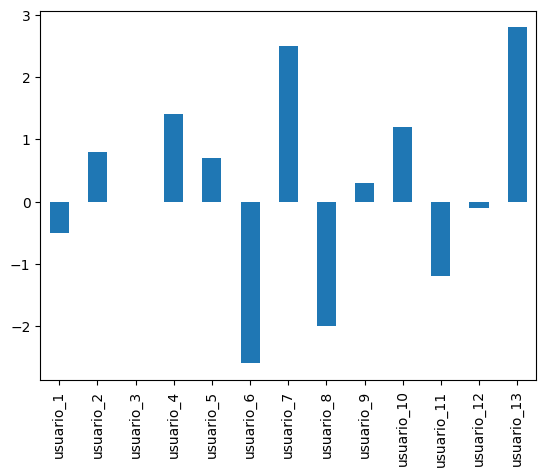

In [16]:
display(df['polaridade_ponderada'].plot(kind='bar'))

## **L**oading

Agora basta salvarmos em algum formato de arquivo nosso dataframe resultante da última etapa. Escolhi salvar em formato Excel, mas pode ser salvo em qualquer outro formato.

In [24]:
df.to_excel('dados_tweets.xlsx', sheet_name='Tweets')
display(pd.read_excel('dados_tweets.xlsx'))

,Unnamed: 0,author,content,date,language,palavras_chaves,polaridade,magnetude,polaridade_ponderada
0,usuario_1,Skywakko (@Skywakko),A mí no me gustó No Man’s Sky por lo mismo que...,"October 5, 2023",es,"[""Man 's Sky motivo Starfield""]",-0.5,0.5,-0.5
1,usuario_2,matthew (@BifocalBore),havent even played baldurs gate 3 yet but im a...,"October 5, 2023",en,"['baldurs gate', 'starfield', '3 100']",0.8,0.8,0.8
2,usuario_3,Edin Rivera (@NewEdin_Faze),Aver diria que la de Starfield se ve un poquit...,"October 5, 2023",es,"['Aver', 'olhar', 'Starfield']",0.0,0.0,0.0
3,usuario_4,Noah McCay 🌵 (@NoahMakesMovies),"Starfield is cool, and all. Like genuinely, I ...","October 5, 2023",en,"['Starfield', 'RPG', 'jogo']",0.7,1.4,1.4
4,usuario_5,DigitalThief (@Garret792),"Las cargas, que deberían haberlas disimulado. ...","October 5, 2023",es,"['fardos', 'Starfield', 'câmera', 'exploração ...",0.1,0.7,0.7
5,usuario_6,Hélastico (@Eliastico_1),Bon voilà après 15h de jeu j’ai désinstallé St...,"October 5, 2023",fr,"['jogo', 'experiência', 'fracasso', 'sentidos'...",-0.6,2.6,-2.6
6,usuario_7,"Myles, Is this easy mode? (@MowzaProduction)",Ship combat is fantastic. You want simulator l...,"October 5, 2023",en,"['combate', 'combate', 'naves', 'veículos', 'j...",0.1,2.5,2.5
7,usuario_8,Gerald (@cereal_killings),Ship combat in Starfield is easily some of the...,"October 5, 2023",en,"['combate', 'Starfield', 'jogo', 'jogo', 'miss...",-0.5,2.0,-2.0
8,usuario_9,Dalerius (@Dalerius1),Reality\nHi-Fi Rush - good (indie game)\nMinec...,"October 5, 2023",en,"['pontuação', 'Medicore Forza Motorsport', 'Fo...",0.3,0.3,0.3
9,usuario_10,SunlessSketcher (@SunlessSketcher),I think my favorite thing about #Starfield is ...,"October 5, 2023",en,"['# Starfield', 'peregrino', 'viagem', 'marido...",0.6,1.2,1.2
